## Simple Shape circuit Extraction Demo notebook

In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
#hardware
device = 'cuda:0'

from circuit_pruner.utils import load_config

config = load_config('/mnt/data/chris/dropbox/Research-Hamblin/Projects/circuit_pruner_cvpr2022/configs/alexnet_sparse_config.py')
model = config.model.to(device)



#general
import torch
import os
from copy import deepcopy
from circuit_pruner.force import setup_net_for_circuit_prune, show_model_layer_names

#### feature target 

In [4]:
layer = 'features_8'
unit = 53

feature_targets = {layer:[unit]}

### general circuit

In [5]:
import os

general_ranks_folder = 'circuit_ranks/alexnet_sparse/imagenet_2/actxgrad/'
general_rank_files = os.listdir(general_ranks_folder)
for file in general_rank_files:
    if '_'+layer+':'+str(unit)+'_' in file:
        print('found')
        general_ranks = torch.load(general_ranks_folder+file)
        break

found


In [6]:
import pickle
df = pickle.load(open('./extracted_circuits/circuit_with20force_df.pkl','rb'))

In [7]:
df.loc[(df['model']=='alexnet_sparse') & (df['layer']==layer) & (df['method']=='actxgrad') & (df['unit']==unit)][['sparsity','effective_sparsity','pruned_pearson']]

sparsity  effective_sparsity  pruned_pearson
41991     0.001            0.000000        0.000000
41992     0.005            0.000658        0.304487
41993     0.010            0.003049        0.131389
41994     0.050            0.039842        0.495238
41995     0.100            0.096175        0.815591
41996     0.200            0.199372        0.951118
41997     0.300            0.299958        0.992698
41998     0.400            0.399887        0.999631
41999     0.500            0.499677        0.999998
42000     0.600            0.599813        1.000000
42001     0.700            0.699938        1.000000
42002     0.800            0.799993        1.000000
42003     0.900            0.900002        1.000000

In [8]:
from circuit_pruner.extraction import model_ranks_2_circuit_model
from circuit_pruner.utils import circuit_2_model_sparsity

sparsity = .4

general_circuit,general_mask = model_ranks_2_circuit_model(general_ranks,sparsity,model,
                                                                     feature_targets,device,structure='edges',
                                                                     use_effective_mask=True)

general_circuit = general_circuit.eval().to('cpu')

for l in general_mask:
    l = l.to('cpu')
    
    
circuit_feature_targets = {layer:[0]}

general_circuit_sparsity_factor = circuit_2_model_sparsity(general_circuit,model)

features_8 effective last layer
target sparsity: 0.4
total params to feature: 86592

kept params in original mask: 34637      (total params * sparsity)
original mask: 483772 params
effective mask: 483682 params
effective_sparsity: 0.39987527716186255
filter sparsity: 0.7236234294161124
kernel sparsity: 0.5526013405681456


In [10]:
general_circuit_sparsity_factor

0.39987527716186255

#### feature visualization of general circuit

------------------------------------------------------------------------------
        Layer (type)    map size      start       jump receptive_field 
        0             [224, 224]        0.5        1.0             1.0 
        1               [55, 55]        3.5        4.0            11.0 
        2               [55, 55]        3.5        4.0            11.0 
        3               [27, 27]        7.5        8.0            19.0 
        4               [27, 27]        7.5        8.0            51.0 
        5               [27, 27]        7.5        8.0            51.0 
        6               [13, 13]       15.5       16.0            67.0 
        7               [13, 13]       15.5       16.0            99.0 
        8               [13, 13]       15.5       16.0            99.0 
        9               [13, 13]       15.5       16.0           131.0 


100%|██████████| 512/512 [00:17<00:00, 29.90it/s]



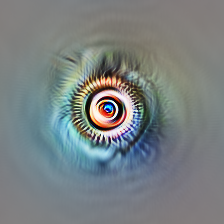

(13, 13)
(6, 6)
[(46.0, 177.0), (46.0, 177.0)]


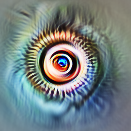

In [8]:
from circuit_pruner.visualizer.featureviz  import featviz_in_recep_field


featviz_in_recep_field(deepcopy(general_circuit),layer,0,margin=0)

100%|██████████| 512/512 [00:26<00:00, 19.06it/s]



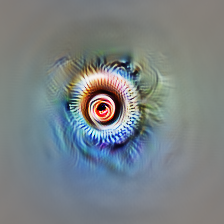

In [13]:
from lucent_fresh.optvis import render, param, transform, objectives   #lucent fresh is a version of lucent with some of my edits
from lucent_fresh.modelzoo.util import get_model_layers

from torchvision import models

model = models.alexnet(pretrained=True)

#this is a bit of a hack to get visualizations to work

from copy import deepcopy
from circuit_pruner.dissected_Conv2d import dissect_model

dis_model = dissect_model(deepcopy(model), store_ranks = True, device=device)
dis_model = dis_model.to(device).eval()



param_f = lambda: param.image(224)

obj  = objectives.neuron(layer,unit)

featviz = render.render_vis(dis_model,  obj, param_f, show_inline=True) #weird hack here using the 'dissected_model' works better for neuron-wise feature visualizations, not sure why


### dataloaders

#### preprocess

In [14]:
from torchvision import transforms
from circuit_pruner.receptive_fields import receptive_field_fit_transform

target_position = [5,5]   #which location of the target filter's activation map do we want to fit these images to
rff_transform = receptive_field_fit_transform(layer,target_position,model=general_circuit)
#try adding the argument "shrinkage = .5" above

preprocess = config.preprocess
preprocess =  transforms.Compose([preprocess,
                                  rff_transform])

------------------------------------------------------------------------------
        Layer (type)    map size      start       jump receptive_field 
        0             [244, 244]        0.5        1.0             1.0 
        1               [60, 60]        3.5        4.0            11.0 
        2               [60, 60]        3.5        4.0            11.0 
        3               [29, 29]        7.5        8.0            19.0 
        4               [29, 29]        7.5        8.0            51.0 
        5               [29, 29]        7.5        8.0            51.0 
        6               [14, 14]       15.5       16.0            67.0 
        7               [14, 14]       15.5       16.0            99.0 
        8               [14, 14]       15.5       16.0            99.0 
        9               [14, 14]       15.5       16.0           131.0 
[(30.0, 161.0), (30.0, 161.0)]


/home/chris/miniconda3/envs/viscnn/lib/python3.7/site-packages/torch/nn/functional.py:3121: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


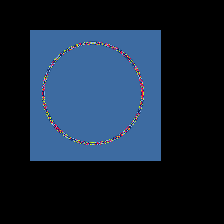

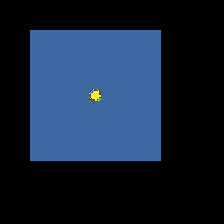

In [15]:
from PIL import Image, ImageOps
from torchvision import transforms
import os

topil = transforms.ToPILImage()

images = ['empty_circle.jpg','small_circle.jpg']

img_root_path = '/mnt/data/chris/dropbox/Research-Hamblin/Projects/circuit_pruner_cvpr2022/image_data/sample_data/circles/'
for image in images:
    img = Image.open(os.path.join(img_root_path,image))
    img_t = preprocess(img)
    img = topil(img_t)
    display(img)

#### dataloader classes

In [16]:
from circuit_pruner.data_loading import rank_image_data
from circuit_pruner.data_loading import single_image_data
from torchvision import transforms
from torch.utils import data



kwargs = {'num_workers': 1, 'pin_memory': True, 'sampler':None} if 'cuda' in device else {}

dataloaders = {}

for image in images:
    dataloaders[image] = data.DataLoader(single_image_data(img_root_path +image,preprocess),
                                         batch_size=1,
                                         shuffle=False,
                                         **kwargs)
    



#### generate ranks

In [17]:
from circuit_pruner.dissected_Conv2d import set_across_model, set_model_target_node
from circuit_pruner.dissected_Conv2d import get_ranklist_from_dissected_Conv2d_modules, clear_ranks_across_model
from copy import deepcopy
from circuit_pruner.dissected_Conv2d import dissect_model

structure = 'kernels'

ranks = {}


for image in images:
    print(image)
    
    rankable_model = dissect_model(deepcopy(general_circuit), dissect=True,store_ranks = True, device=device)
    rankable_model.to(device)

    set_model_target_node(rankable_model,layer,0)

    set_across_model(rankable_model,'rank_field',target_position)#we want to get ranks with respect to our filters response at the target position 

    set_across_model(rankable_model,'absolute_rank',True)
    
    iter_dataloader = iter(dataloaders[image])
    iters = len(iter_dataloader)

    #actually extract ranks by running images through model
    clear_ranks_across_model(rankable_model)

    for it in range(iters):

        inputs, label = next(iter_dataloader)
        inputs = inputs.to(device)

        rankable_model.zero_grad()

        try:
            outputs = rankable_model(inputs)
        except:
            pass


    ranks[image] = get_ranklist_from_dissected_Conv2d_modules(rankable_model)
    
    del rankable_model
    torch.cuda.empty_cache()

empty_circle.jpg
small_circle.jpg


In [18]:
from circuit_pruner.ranks import minmax_norm_ranks

normed_ranks = {}
for image in images:
    normed_ranks[image] = minmax_norm_ranks(ranks[image])

#### activation preservation as function of sparsity

In [19]:
from circuit_pruner.extraction import get_preservation_at_sparsities
import numpy as np

ranker = ranks

structure='kernels'


sparsities = np.linspace(.9999, .01, num=70)

model_sparsities = []
for sparsity in sparsities:
    model_sparsities.append(sparsity*general_circuit_sparsity_factor) 


scores = {}
for image in images:
    scores[image.replace('.jpg','_circuit')] = {}

for rank_image in images:
    for data_image in images:
        print('\n\n\n')
        print(rank_image)
        print(data_image)
        print('\n\n\n')
        scores[rank_image.replace('.jpg','_circuit')][data_image.replace('.jpg','_data')] = get_preservation_at_sparsities(
            
                                                                general_circuit,
                                                                ranker[rank_image],
                                                                circuit_feature_targets,
                                                                dataloaders[data_image],
                                                                sparsities,device,metric='all',
                                                                rank_field = target_position,
                                                                structure=structure)






empty_circle.jpg
empty_circle.jpg




original
features_8 effective last layer
average orig acts:
feature features_8:0: 7.366720676422119
Target Sparsity: 0.9999
features_8 effective last layer
target sparsity: 0.9999
total params to feature: 62660

we found 28034 params that were already zero'd out, your model is already a pruned circuit right? . . . 			   just making sure, we are subtracting these params from the total.

new total params: 34626    (after subtracting previously masked params)
kept params in original mask: 34623      (total params * sparsity)
gradients from this feature are sparse,the minimum acceptable rank at this sparsity has a score of zero! we will return a mask thats smaller than you asked, by masking all parameters with a score of zero.
original mask: 483682 params
effective mask: 483682 params
effective_sparsity: 1.0


/mnt/data/chris/dropbox/Research-Hamblin/Projects/circuit_pruner_cvpr2022/circuit_pruner/extraction.py:251: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /opt/conda/conda-bld/pytorch_1595629427478/work/torch/csrc/utils/python_arg_parser.cpp:766.)
  possible_flip_indices = possible_flips.nonzero()


features_8 effective last layer
average circuit acts:
feature features_8:0: 7.366720676422119
Target Sparsity: 0.9855536231884058
features_8 effective last layer
target sparsity: 0.9855536231884058
total params to feature: 62660

we found 28034 params that were already zero'd out, your model is already a pruned circuit right? . . . 			   just making sure, we are subtracting these params from the total.

new total params: 34626    (after subtracting previously masked params)
kept params in original mask: 34126      (total params * sparsity)
gradients from this feature are sparse,the minimum acceptable rank at this sparsity has a score of zero! we will return a mask thats smaller than you asked, by masking all parameters with a score of zero.
original mask: 483682 params
effective mask: 483682 params
effective_sparsity: 1.0


/mnt/data/chris/dropbox/Research-Hamblin/Projects/circuit_pruner_cvpr2022/circuit_pruner/extraction.py:738: RuntimeWarning: invalid value encountered in float_scalars
  score = np.mean(acts[feature]-orig_acts[orig_feature])/norm_factor
/mnt/data/chris/dropbox/Research-Hamblin/Projects/circuit_pruner_cvpr2022/circuit_pruner/extraction.py:757: RuntimeWarning: invalid value encountered in float_scalars
  score = np.mean(np.abs(acts[feature]-orig_acts[orig_feature]))/norm_factor


features_8 effective last layer
average circuit acts:
feature features_8:0: 7.366720676422119
Target Sparsity: 0.9712072463768116
features_8 effective last layer
target sparsity: 0.9712072463768116
total params to feature: 62660

we found 28034 params that were already zero'd out, your model is already a pruned circuit right? . . . 			   just making sure, we are subtracting these params from the total.

new total params: 34626    (after subtracting previously masked params)
kept params in original mask: 33630      (total params * sparsity)
gradients from this feature are sparse,the minimum acceptable rank at this sparsity has a score of zero! we will return a mask thats smaller than you asked, by masking all parameters with a score of zero.
original mask: 466564 params
effective mask: 461884 params
effective_sparsity: 0.9577773927106799
features_8 effective last layer
average circuit acts:
feature features_8:0: 7.366720676422119
Target Sparsity: 0.9568608695652174
features_8 effective 

/mnt/data/chris/dropbox/Research-Hamblin/Projects/circuit_pruner_cvpr2022/circuit_pruner/extraction.py:738: RuntimeWarning: divide by zero encountered in float_scalars
  score = np.mean(acts[feature]-orig_acts[orig_feature])/norm_factor
/mnt/data/chris/dropbox/Research-Hamblin/Projects/circuit_pruner_cvpr2022/circuit_pruner/extraction.py:757: RuntimeWarning: divide by zero encountered in float_scalars
  score = np.mean(np.abs(acts[feature]-orig_acts[orig_feature]))/norm_factor


features_8 effective last layer
average circuit acts:
feature features_8:0: 7.366720676422119
Target Sparsity: 0.928168115942029
features_8 effective last layer
target sparsity: 0.928168115942029
total params to feature: 62660

we found 28034 params that were already zero'd out, your model is already a pruned circuit right? . . . 			   just making sure, we are subtracting these params from the total.

new total params: 34626    (after subtracting previously masked params)
kept params in original mask: 32139      (total params * sparsity)
gradients from this feature are sparse,the minimum acceptable rank at this sparsity has a score of zero! we will return a mask thats smaller than you asked, by masking all parameters with a score of zero.
original mask: 453145 params
effective mask: 449257 params
effective_sparsity: 0.9172587073297522
features_8 effective last layer
average circuit acts:
feature features_8:0: 7.366720676422119
Target Sparsity: 0.9138217391304349
features_8 effective la

features_8 effective last layer
average circuit acts:
feature features_8:0: 7.349775791168213
Target Sparsity: 0.7703579710144928
features_8 effective last layer
target sparsity: 0.7703579710144928
total params to feature: 62660

we found 28034 params that were already zero'd out, your model is already a pruned circuit right? . . . 			   just making sure, we are subtracting these params from the total.

new total params: 34626    (after subtracting previously masked params)
kept params in original mask: 26675      (total params * sparsity)
original mask: 402379 params
effective mask: 402253 params
effective_sparsity: 0.7699705423670075
features_8 effective last layer
average circuit acts:
feature features_8:0: 7.34132194519043
Target Sparsity: 0.7560115942028985
features_8 effective last layer
target sparsity: 0.7560115942028985
total params to feature: 62660

we found 28034 params that were already zero'd out, your model is already a pruned circuit right? . . . 			   just making sure,

features_8 effective last layer
average circuit acts:
feature features_8:0: 7.352405071258545
Target Sparsity: 0.5838550724637681
features_8 effective last layer
target sparsity: 0.5838550724637681
total params to feature: 62660

we found 28034 params that were already zero'd out, your model is already a pruned circuit right? . . . 			   just making sure, we are subtracting these params from the total.

new total params: 34626    (after subtracting previously masked params)
kept params in original mask: 20217      (total params * sparsity)
original mask: 317809 params
effective mask: 317044 params
effective_sparsity: 0.5814128111823486
features_8 effective last layer
average circuit acts:
feature features_8:0: 7.393506050109863
Target Sparsity: 0.569508695652174
features_8 effective last layer
target sparsity: 0.569508695652174
total params to feature: 62660

we found 28034 params that were already zero'd out, your model is already a pruned circuit right? . . . 			   just making sure, 

features_8 effective last layer
average circuit acts:
feature features_8:0: 7.475965976715088
Target Sparsity: 0.39735217391304345
features_8 effective last layer
target sparsity: 0.39735217391304345
total params to feature: 62660

we found 28034 params that were already zero'd out, your model is already a pruned circuit right? . . . 			   just making sure, we are subtracting these params from the total.

new total params: 34626    (after subtracting previously masked params)
kept params in original mask: 13759      (total params * sparsity)
original mask: 217431 params
effective mask: 214625 params
effective_sparsity: 0.3902558770865823
features_8 effective last layer
average circuit acts:
feature features_8:0: 7.315371036529541
Target Sparsity: 0.38300579710144933
features_8 effective last layer
target sparsity: 0.38300579710144933
total params to feature: 62660

we found 28034 params that were already zero'd out, your model is already a pruned circuit right? . . . 			   just making 

features_8 effective last layer
average circuit acts:
feature features_8:0: 6.193762302398682
Target Sparsity: 0.2108492753623189
features_8 effective last layer
target sparsity: 0.2108492753623189
total params to feature: 62660

we found 28034 params that were already zero'd out, your model is already a pruned circuit right? . . . 			   just making sure, we are subtracting these params from the total.

new total params: 34626    (after subtracting previously masked params)
kept params in original mask: 7301      (total params * sparsity)
original mask: 114781 params
effective mask: 110354 params
effective_sparsity: 0.20152486570784958
features_8 effective last layer
average circuit acts:
feature features_8:0: 6.42136812210083
Target Sparsity: 0.19650289855072467
features_8 effective last layer
target sparsity: 0.19650289855072467
total params to feature: 62660

we found 28034 params that were already zero'd out, your model is already a pruned circuit right? . . . 			   just making sur

features_8 effective last layer
average circuit acts:
feature features_8:0: 0.9725149869918823
Target Sparsity: 0.02434637681159424
features_8 effective last layer
target sparsity: 0.02434637681159424
total params to feature: 62660

we found 28034 params that were already zero'd out, your model is already a pruned circuit right? . . . 			   just making sure, we are subtracting these params from the total.

new total params: 34626    (after subtracting previously masked params)
kept params in original mask: 844      (total params * sparsity)
original mask: 11324 params
effective mask: 1600 params
effective_sparsity: 0.0032345636227112573
features_8 effective last layer
average circuit acts:
feature features_8:0: 0.4193250834941864
Target Sparsity: 0.01
features_8 effective last layer
target sparsity: 0.01
total params to feature: 62660

we found 28034 params that were already zero'd out, your model is already a pruned circuit right? . . . 			   just making sure, we are subtracting these

original mask: 439735 params
effective mask: 436720 params
effective_sparsity: 0.877028822272281
features_8 effective last layer
average circuit acts:
feature features_8:0: 17.885194778442383
Target Sparsity: 0.8707826086956522
features_8 effective last layer
target sparsity: 0.8707826086956522
total params to feature: 62660

we found 28034 params that were already zero'd out, your model is already a pruned circuit right? . . . 			   just making sure, we are subtracting these params from the total.

new total params: 34626    (after subtracting previously masked params)
kept params in original mask: 30152      (total params * sparsity)
gradients from this feature are sparse,the minimum acceptable rank at this sparsity has a score of zero! we will return a mask thats smaller than you asked, by masking all parameters with a score of zero.
original mask: 435262 params
effective mask: 432751 params
effective_sparsity: 0.8642927280078554
features_8 effective last layer
average circuit acts:

features_8 effective last layer
average circuit acts:
feature features_8:0: 16.693246841430664
Target Sparsity: 0.6986260869565217
features_8 effective last layer
target sparsity: 0.6986260869565217
total params to feature: 62660

we found 28034 params that were already zero'd out, your model is already a pruned circuit right? . . . 			   just making sure, we are subtracting these params from the total.

new total params: 34626    (after subtracting previously masked params)
kept params in original mask: 24191      (total params * sparsity)
original mask: 374199 params
effective mask: 373893 params
effective_sparsity: 0.6976549413735343
features_8 effective last layer
average circuit acts:
feature features_8:0: 15.176006317138672
Target Sparsity: 0.6842797101449276
features_8 effective last layer
target sparsity: 0.6842797101449276
total params to feature: 62660

we found 28034 params that were already zero'd out, your model is already a pruned circuit right? . . . 			   just making su

features_8 effective last layer
average circuit acts:
feature features_8:0: 15.880741119384766
Target Sparsity: 0.5121231884057971
features_8 effective last layer
target sparsity: 0.5121231884057971
total params to feature: 62660

we found 28034 params that were already zero'd out, your model is already a pruned circuit right? . . . 			   just making sure, we are subtracting these params from the total.

new total params: 34626    (after subtracting previously masked params)
kept params in original mask: 17733      (total params * sparsity)
original mask: 279549 params
effective mask: 278516 params
effective_sparsity: 0.5097903309651707
features_8 effective last layer
average circuit acts:
feature features_8:0: 15.736474990844727
Target Sparsity: 0.49777681159420295
features_8 effective last layer
target sparsity: 0.49777681159420295
total params to feature: 62660

we found 28034 params that were already zero'd out, your model is already a pruned circuit right? . . . 			   just making 

features_8 effective last layer
average circuit acts:
feature features_8:0: 6.64966344833374
Target Sparsity: 0.3256202898550725
features_8 effective last layer
target sparsity: 0.3256202898550725
total params to feature: 62660

we found 28034 params that were already zero'd out, your model is already a pruned circuit right? . . . 			   just making sure, we are subtracting these params from the total.

new total params: 34626    (after subtracting previously masked params)
kept params in original mask: 11275      (total params * sparsity)
original mask: 178067 params
effective mask: 174539 params
effective_sparsity: 0.3175359556402703
features_8 effective last layer
average circuit acts:
feature features_8:0: 6.829165458679199
Target Sparsity: 0.3112739130434783
features_8 effective last layer
target sparsity: 0.3112739130434783
total params to feature: 62660

we found 28034 params that were already zero'd out, your model is already a pruned circuit right? . . . 			   just making sure,

features_8 effective last layer
average circuit acts:
feature features_8:0: 1.768048644065857
Target Sparsity: 0.13911739130434786
features_8 effective last layer
target sparsity: 0.13911739130434786
total params to feature: 62660

we found 28034 params that were already zero'd out, your model is already a pruned circuit right? . . . 			   just making sure, we are subtracting these params from the total.

new total params: 34626    (after subtracting previously masked params)
kept params in original mask: 4818      (total params * sparsity)
original mask: 73330 params
effective mask: 66174 params
effective_sparsity: 0.12239357708080634
features_8 effective last layer
average circuit acts:
feature features_8:0: 1.0414832830429077
Target Sparsity: 0.12477101449275363
features_8 effective last layer
target sparsity: 0.12477101449275363
total params to feature: 62660

we found 28034 params that were already zero'd out, your model is already a pruned circuit right? . . . 			   just making s

original mask: 472475 params
effective mask: 468668 params
effective_sparsity: 0.9610119563333911
features_8 effective last layer
average circuit acts:
feature features_8:0: 6.36455774307251
Target Sparsity: 0.9568608695652174
features_8 effective last layer
target sparsity: 0.9568608695652174
total params to feature: 62660

we found 28034 params that were already zero'd out, your model is already a pruned circuit right? . . . 			   just making sure, we are subtracting these params from the total.

new total params: 34626    (after subtracting previously masked params)
kept params in original mask: 33133      (total params * sparsity)
gradients from this feature are sparse,the minimum acceptable rank at this sparsity has a score of zero! we will return a mask thats smaller than you asked, by masking all parameters with a score of zero.
original mask: 468002 params
effective mask: 464330 params
effective_sparsity: 0.9470917807427944
features_8 effective last layer
average circuit acts:


features_8 effective last layer
average circuit acts:
feature features_8:0: 7.94390344619751
Target Sparsity: 0.8133971014492754
features_8 effective last layer
target sparsity: 0.8133971014492754
total params to feature: 62660

we found 28034 params that were already zero'd out, your model is already a pruned circuit right? . . . 			   just making sure, we are subtracting these params from the total.

new total params: 34626    (after subtracting previously masked params)
kept params in original mask: 28165      (total params * sparsity)
gradients from this feature are sparse,the minimum acceptable rank at this sparsity has a score of zero! we will return a mask thats smaller than you asked, by masking all parameters with a score of zero.
original mask: 423290 params
effective mask: 422264 params
effective_sparsity: 0.8121065095592908
features_8 effective last layer
average circuit acts:
feature features_8:0: 7.9466376304626465
Target Sparsity: 0.7990507246376812
features_8 effective 

features_8 effective last layer
average circuit acts:
feature features_8:0: 8.245407104492188
Target Sparsity: 0.6268942028985507
features_8 effective last layer
target sparsity: 0.6268942028985507
total params to feature: 62660

we found 28034 params that were already zero'd out, your model is already a pruned circuit right? . . . 			   just making sure, we are subtracting these params from the total.

new total params: 34626    (after subtracting previously masked params)
kept params in original mask: 21707      (total params * sparsity)
original mask: 345331 params
effective mask: 344201 params
effective_sparsity: 0.6233754981805579
features_8 effective last layer
average circuit acts:
feature features_8:0: 8.508573532104492
Target Sparsity: 0.6125478260869566
features_8 effective last layer
target sparsity: 0.6125478260869566
total params to feature: 62660

we found 28034 params that were already zero'd out, your model is already a pruned circuit right? . . . 			   just making sure

features_8 effective last layer
average circuit acts:
feature features_8:0: 3.4080395698547363
Target Sparsity: 0.44039130434782614
features_8 effective last layer
target sparsity: 0.44039130434782614
total params to feature: 62660

we found 28034 params that were already zero'd out, your model is already a pruned circuit right? . . . 			   just making sure, we are subtracting these params from the total.

new total params: 34626    (after subtracting previously masked params)
kept params in original mask: 15249      (total params * sparsity)
original mask: 242329 params
effective mask: 240143 params
effective_sparsity: 0.4345578467047883
features_8 effective last layer
average circuit acts:
feature features_8:0: 3.886348009109497
Target Sparsity: 0.4260449275362319
features_8 effective last layer
target sparsity: 0.4260449275362319
total params to feature: 62660

we found 28034 params that were already zero'd out, your model is already a pruned circuit right? . . . 			   just making s

features_8 effective last layer
average circuit acts:
feature features_8:0: 0.46852782368659973
Target Sparsity: 0.2538884057971015
features_8 effective last layer
target sparsity: 0.2538884057971015
total params to feature: 62660

we found 28034 params that were already zero'd out, your model is already a pruned circuit right? . . . 			   just making sure, we are subtracting these params from the total.

new total params: 34626    (after subtracting previously masked params)
kept params in original mask: 8792      (total params * sparsity)
original mask: 137176 params
effective mask: 133215 params
effective_sparsity: 0.2441806734823543
features_8 effective last layer
average circuit acts:
feature features_8:0: 0.42884162068367004
Target Sparsity: 0.23954202898550725
features_8 effective last layer
target sparsity: 0.23954202898550725
total params to feature: 62660

we found 28034 params that were already zero'd out, your model is already a pruned circuit right? . . . 			   just making

features_8 effective last layer
average circuit acts:
feature features_8:0: -0.5786586999893188
Target Sparsity: 0.06738550724637682
features_8 effective last layer
target sparsity: 0.06738550724637682
total params to feature: 62660

we found 28034 params that were already zero'd out, your model is already a pruned circuit right? . . . 			   just making sure, we are subtracting these params from the total.

new total params: 34626    (after subtracting previously masked params)
kept params in original mask: 2334      (total params * sparsity)
original mask: 33390 params
effective mask: 19409 params
effective_sparsity: 0.03584012014093456
features_8 effective last layer
average circuit acts:
feature features_8:0: -0.440024197101593
Target Sparsity: 0.05303913043478259
features_8 effective last layer
target sparsity: 0.05303913043478259
total params to feature: 62660

we found 28034 params that were already zero'd out, your model is already a pruned circuit right? . . . 			   just making

original mask: 459056 params
effective mask: 455618 params
effective_sparsity: 0.9191359094322186
features_8 effective last layer
average circuit acts:
feature features_8:0: 20.073650360107422
Target Sparsity: 0.9138217391304349
features_8 effective last layer
target sparsity: 0.9138217391304349
total params to feature: 62660

we found 28034 params that were already zero'd out, your model is already a pruned circuit right? . . . 			   just making sure, we are subtracting these params from the total.

new total params: 34626    (after subtracting previously masked params)
kept params in original mask: 31642      (total params * sparsity)
gradients from this feature are sparse,the minimum acceptable rank at this sparsity has a score of zero! we will return a mask thats smaller than you asked, by masking all parameters with a score of zero.
original mask: 454583 params
effective mask: 451217 params
effective_sparsity: 0.9050135736152024
features_8 effective last layer
average circuit acts

features_8 effective last layer
average circuit acts:
feature features_8:0: 20.070423126220703
Target Sparsity: 0.7703579710144928
features_8 effective last layer
target sparsity: 0.7703579710144928
total params to feature: 62660

we found 28034 params that were already zero'd out, your model is already a pruned circuit right? . . . 			   just making sure, we are subtracting these params from the total.

new total params: 34626    (after subtracting previously masked params)
kept params in original mask: 26675      (total params * sparsity)
original mask: 408475 params
effective mask: 408466 params
effective_sparsity: 0.7703459827875008
features_8 effective last layer
average circuit acts:
feature features_8:0: 20.056608200073242
Target Sparsity: 0.7560115942028985
features_8 effective last layer
target sparsity: 0.7560115942028985
total params to feature: 62660

we found 28034 params that were already zero'd out, your model is already a pruned circuit right? . . . 			   just making su

features_8 effective last layer
average circuit acts:
feature features_8:0: 24.3466854095459
Target Sparsity: 0.5838550724637681
features_8 effective last layer
target sparsity: 0.5838550724637681
total params to feature: 62660

we found 28034 params that were already zero'd out, your model is already a pruned circuit right? . . . 			   just making sure, we are subtracting these params from the total.

new total params: 34626    (after subtracting previously masked params)
kept params in original mask: 20217      (total params * sparsity)
original mask: 321969 params
effective mask: 320511 params
effective_sparsity: 0.5791890486917345
features_8 effective last layer
average circuit acts:
feature features_8:0: 25.637435913085938
Target Sparsity: 0.569508695652174
features_8 effective last layer
target sparsity: 0.569508695652174
total params to feature: 62660

we found 28034 params that were already zero'd out, your model is already a pruned circuit right? . . . 			   just making sure, 

features_8 effective last layer
average circuit acts:
feature features_8:0: 26.038291931152344
Target Sparsity: 0.39735217391304345
features_8 effective last layer
target sparsity: 0.39735217391304345
total params to feature: 62660

we found 28034 params that were already zero'd out, your model is already a pruned circuit right? . . . 			   just making sure, we are subtracting these params from the total.

new total params: 34626    (after subtracting previously masked params)
kept params in original mask: 13759      (total params * sparsity)
original mask: 218215 params
effective mask: 215460 params
effective_sparsity: 0.389649396407324
features_8 effective last layer
average circuit acts:
feature features_8:0: 21.370548248291016
Target Sparsity: 0.38300579710144933
features_8 effective last layer
target sparsity: 0.38300579710144933
total params to feature: 62660

we found 28034 params that were already zero'd out, your model is already a pruned circuit right? . . . 			   just making

features_8 effective last layer
average circuit acts:
feature features_8:0: 15.515792846679688
Target Sparsity: 0.2108492753623189
features_8 effective last layer
target sparsity: 0.2108492753623189
total params to feature: 62660

we found 28034 params that were already zero'd out, your model is already a pruned circuit right? . . . 			   just making sure, we are subtracting these params from the total.

new total params: 34626    (after subtracting previously masked params)
kept params in original mask: 7301      (total params * sparsity)
original mask: 113085 params
effective mask: 108622 params
effective_sparsity: 0.19909894299081615
features_8 effective last layer
average circuit acts:
feature features_8:0: 14.98755168914795
Target Sparsity: 0.19650289855072467
features_8 effective last layer
target sparsity: 0.19650289855072467
total params to feature: 62660

we found 28034 params that were already zero'd out, your model is already a pruned circuit right? . . . 			   just making s

features_8 effective last layer
average circuit acts:
feature features_8:0: 7.647675514221191
Target Sparsity: 0.02434637681159424
features_8 effective last layer
target sparsity: 0.02434637681159424
total params to feature: 62660

we found 28034 params that were already zero'd out, your model is already a pruned circuit right? . . . 			   just making sure, we are subtracting these params from the total.

new total params: 34626    (after subtracting previously masked params)
kept params in original mask: 844      (total params * sparsity)
original mask: 11148 params
effective mask: 1909 params
effective_sparsity: 0.0036100040432045285
features_8 effective last layer
average circuit acts:
feature features_8:0: 2.173938035964966
Target Sparsity: 0.01
features_8 effective last layer
target sparsity: 0.01
total params to feature: 62660

we found 28034 params that were already zero'd out, your model is already a pruned circuit right? . . . 			   just making sure, we are subtracting these p

In [38]:
import pickle

pickle.dump(scores,open('plots/circle_scores.pkl','wb'))

In [20]:
model_sparsities = []
for sparsity in sparsities:
    model_sparsities.append(sparsity*general_circuit_sparsity_factor) 

In [39]:
import plotly.graph_objects as go
import plotly.express as px


x_axis = sparsities

metric = 'mean_normed_diff'

color_dict = {
               'empty_circle_circuit':px.colors.qualitative.T10[0],
               'small_circle_circuit':px.colors.qualitative.T10[1],
               #'right_circuit':px.colors.qualitative.T10[4],
             }




fig = go.Figure()

for circuit in scores:
    for data in scores[circuit]:
        # Create and style traces
        if data.replace('_data','') == circuit.replace('_circuit',''):
            linetype = None
        else:
            linetype = 'dot'
            
        name = (circuit+' : '+data).replace('_',' ').replace('empty','big').replace('data','image')
        y = scores[circuit][data]['%s:%s'%(layer,0)][metric]
        x = x_axis[0:len(scores[circuit][data]['%s:%s'%(layer,0)][metric])]
        fig.add_trace(go.Scatter(x=x, y=y, name=name,
                         line=dict(color=color_dict[circuit], width=4,dash=linetype)))

# Edit the layout
fig.update_layout( width = 720,
                   plot_bgcolor = 'rgba(255,255,255,1)',
                   paper_bgcolor = 'rgba(255,255,255,1)',
                   xaxis_title='sparsity',
                   yaxis_title='normed activation difference (circuit-model)',
                  legend=dict(
                                yanchor="top",
                                y=0.35,
                                xanchor="left",
                                x=0.03
                              )
                 )
fig.update_xaxes(autorange="reversed")


fig.show()

In [23]:
fig.write_html("plots/circle_activation_diff.html")
fig.write_image("plots/circle_activation_diff.svg")
fig.write_image("plots/circle_activation_diff.png")

#### Extract circuits at preserving sparsity

In [40]:
# extraction at last good sparsity

from circuit_pruner.extraction import model_ranks_2_circuit_model

ranker = ranks

# target_sparsities = {'empty_circle.jpg':0.1534638,
#                      'small_circle.jpg':0.05303913}
target_sparsities = {'empty_circle.jpg':0.124771,
                     'small_circle.jpg':.08173} 

sparse_circuits = {}
sparse_masks = {}

for image in images:
    sparse_circuit,sparse_mask = model_ranks_2_circuit_model(normed_ranks[image],target_sparsities[image],
                                                           general_circuit,circuit_feature_targets,device,
                                                           structure='kernels',use_effective_mask=True,
                                                           rank_field=target_position)
    sparse_circuits[image] = sparse_circuit.to(device)
    sparse_masks[image] = sparse_mask


features_8 effective last layer
target sparsity: 0.124771
total params to feature: 62660

we found 28034 params that were already zero'd out, your model is already a pruned circuit right? . . . 			   just making sure, we are subtracting these params from the total.

new total params: 34626    (after subtracting previously masked params)
kept params in original mask: 4321      (total params * sparsity)
original mask: 91177 params
effective mask: 73822 params
effective_sparsity: 0.09975163172182752
features_8 effective last layer
target sparsity: 0.08173
total params to feature: 62660

we found 28034 params that were already zero'd out, your model is already a pruned circuit right? . . . 			   just making sure, we are subtracting these params from the total.

new total params: 34626    (after subtracting previously masked params)
kept params in original mask: 2830      (total params * sparsity)
original mask: 65102 params
effective mask: 55642 params
effective_sparsity: 0.069600877952983

In [41]:
sparse_circuits

{'empty_circle.jpg': Sequential(
   (features_0): Conv2d(3, 43, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
   (features_1): ReLU(inplace=True)
   (features_2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
   (features_3): Conv2d(43, 157, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
   (features_4): ReLU(inplace=True)
   (features_5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
   (features_6): Conv2d(157, 67, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (features_7): ReLU(inplace=True)
   (features_8): Conv2d(67, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
 ),
 'small_circle.jpg': Sequential(
   (features_0): Conv2d(3, 50, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
   (features_1): ReLU(inplace=True)
   (features_2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
   (features_3): Conv2d(50, 125, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
   (feat

In [42]:
from circuit_pruner.visualizer.featureviz  import featviz_in_recep_field

  1%|          | 4/512 [00:00<00:13, 38.88it/s]

------------------------------------------------------------------------------
        Layer (type)    map size      start       jump receptive_field 
        0             [224, 224]        0.5        1.0             1.0 
        1               [55, 55]        3.5        4.0            11.0 
        2               [55, 55]        3.5        4.0            11.0 
        3               [27, 27]        7.5        8.0            19.0 
        4               [27, 27]        7.5        8.0            51.0 
        5               [27, 27]        7.5        8.0            51.0 
        6               [13, 13]       15.5       16.0            67.0 
        7               [13, 13]       15.5       16.0            99.0 
        8               [13, 13]       15.5       16.0            99.0 
        9               [13, 13]       15.5       16.0           131.0 


100%|██████████| 512/512 [00:12<00:00, 39.90it/s]



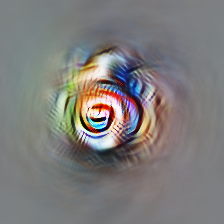

(13, 13)
(6, 6)
[(46.0, 177.0), (46.0, 177.0)]


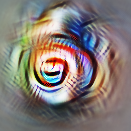

In [43]:
featviz_in_recep_field(deepcopy(sparse_circuits['empty_circle.jpg']),layer,0,margin=0)

  1%|          | 5/512 [00:00<00:12, 41.24it/s]

------------------------------------------------------------------------------
        Layer (type)    map size      start       jump receptive_field 
        0             [224, 224]        0.5        1.0             1.0 
        1               [55, 55]        3.5        4.0            11.0 
        2               [55, 55]        3.5        4.0            11.0 
        3               [27, 27]        7.5        8.0            19.0 
        4               [27, 27]        7.5        8.0            51.0 
        5               [27, 27]        7.5        8.0            51.0 
        6               [13, 13]       15.5       16.0            67.0 
        7               [13, 13]       15.5       16.0            99.0 
        8               [13, 13]       15.5       16.0            99.0 
        9               [13, 13]       15.5       16.0           131.0 


100%|██████████| 512/512 [00:12<00:00, 40.83it/s]



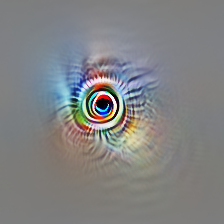

(13, 13)
(6, 6)
[(46.0, 177.0), (46.0, 177.0)]


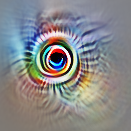

In [44]:
featviz_in_recep_field(deepcopy(sparse_circuits['small_circle.jpg']),layer,0,margin=0)

#### Compare IoU of extracted circuits

In [45]:
from circuit_pruner.utils import plot_iou_from_masks

In [49]:
iou_fig = plot_iou_from_masks(sparse_masks['empty_circle.jpg'],sparse_masks['small_circle.jpg'])
iou_fig.update_layout(height=1000,
                      width=2000)

In [48]:
iou_fig.write_html("plots/circle_iou.html")
iou_fig.write_image("plots/circle_iou.svg")
iou_fig.write_image("plots/circle_iou.png")

#### compare normed scores and scores

In [29]:
import plotly.graph_objects as go
import plotly.express as px


x_axis = sparsities

metric = 'avg_abs_diff'

color_dict = {
               'empty_circle_circuit':px.colors.qualitative.T10[0],
               'small_circle_circuit':px.colors.qualitative.T10[1],
               #'right_circuit':px.colors.qualitative.T10[4],
             }




fig = go.Figure()

for circuit in scores:
    data=circuit.replace('_circuit','_data')

    name = (circuit+' : '+data).replace('_',' ').replace('empty','big').replace('data','image')
    y = np.array(normed_scores[circuit][data]['%s:%s'%(layer,0)][metric][:69])-np.array(scores[circuit][data]['%s:%s'%(layer,0)][metric][:69])
    x = x_axis[0:len(scores[circuit][data]['%s:%s'%(layer,0)][metric])]
    fig.add_trace(go.Scatter(x=x, y=y, name=name,
                     line=dict(color=color_dict[circuit], width=4,dash=None)))

# Edit the layout
fig.update_layout( width = 720,
                   plot_bgcolor = 'rgba(255,255,255,1)',
                   paper_bgcolor = 'rgba(255,255,255,1)',
                   xaxis_title='sparsity',
                   yaxis_title='normed scores - scores',
                  legend=dict(
                                yanchor="top",
                                y=0.35,
                                xanchor="left",
                                x=0.03
                              )
                 )
fig.update_xaxes(autorange="reversed")


fig.show()

In [15]:
#hardware
device = 'cuda:0'

#model loading
from torchvision import models
model = models.alexnet(pretrained=True)
model = model.to(device)

from copy import deepcopy
from circuit_pruner.dissected_Conv2d import dissect_model
dissected_model = dissect_model(deepcopy(model), store_ranks = True, device=device)
dissected_model = dissected_model.to(device)

this function will show us how to reference layers in our model

In [16]:
# from circuit_pruner.force import show_model_layer_names

# show_model_layer_names(model)

### Circle Scale circuits

visualization of 'spiral' target neuron

positive visualization


100%|██████████| 512/512 [00:26<00:00, 19.19it/s]



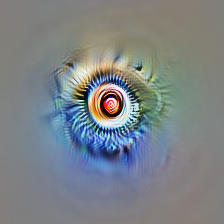

  1%|          | 3/512 [00:00<00:23, 21.47it/s]

negative visualization


100%|██████████| 512/512 [00:25<00:00, 20.19it/s]



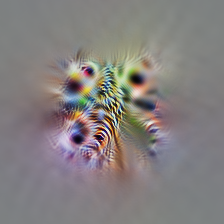

In [4]:
from lucent_fresh.optvis import render, param, transform, objectives   #lucent fresh is a version of lucent with some of my edits
from lucent_fresh.modelzoo.util import get_model_layers

param_f = lambda: param.image(224)
obj  = objectives.neuron(layer,unit)
neg_obj = -obj
print('positive visualization')
_ = render.render_vis(dissected_model,  obj, param_f, transforms=None, show_inline=True) #weird hack here using the 'dissected_model' works better for neuron-wise feature visualizations, not sure why
print('negative visualization')
_ = render.render_vis(dissected_model,  neg_obj, param_f, transforms=None, show_inline=True)

We extract circuits with respect to input images, lets look at the two images we'll use

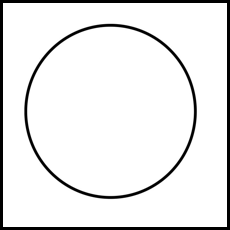

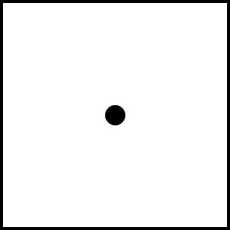

In [18]:
root_image_folder = 'image_data/sample_data/circles/'

from PIL import Image, ImageOps
big_circle_img = Image.open(root_image_folder+'empty_circle.jpg')
small_circle_img = Image.open(root_image_folder+'small_circle.jpg')
big_circle_img = big_circle_img.resize((224,224))
small_circle_img = small_circle_img.resize((224,224))


#displaying with a border to get a sense of scale within image
border = (3, 3, 3, 3)
big_circle_wt_border = ImageOps.expand(big_circle_img, border=border, fill='black')
small_circle_wt_border = ImageOps.expand(small_circle_img, border=border, fill='black')
display(big_circle_wt_border)
display(small_circle_wt_border)

circle_images = {'big':big_circle_img,'small':small_circle_img}

In [25]:
from torchvision import transforms
from circuit_pruner.receptive_fields import receptive_field_fit_transform

target_position = [5,5]   #which location of the target filter's activation map do we want to fit these images to
rff_transform = receptive_field_fit_transform(layer,target_position,model=general_circuit,shrinkage=.8)
#try adding the argument "shrinkage = .5" above

preprocess = config.preprocess
preprocess =  transforms.Compose([preprocess,
                                  rff_transform])

------------------------------------------------------------------------------
        Layer (type)    map size      start       jump receptive_field 
        0             [244, 244]        0.5        1.0             1.0 
        1               [60, 60]        3.5        4.0            11.0 
        2               [60, 60]        3.5        4.0            11.0 
        3               [29, 29]        7.5        8.0            19.0 
        4               [29, 29]        7.5        8.0            51.0 
        5               [29, 29]        7.5        8.0            51.0 
        6               [14, 14]       15.5       16.0            67.0 
        7               [14, 14]       15.5       16.0            99.0 
        8               [14, 14]       15.5       16.0            99.0 
        9               [14, 14]       15.5       16.0           131.0 
[(30.0, 161.0), (30.0, 161.0)]


NameError: name 'config' is not defined

One thing that comes up again and again, which we will utilize here, is the calculation of analytical receptive fields. For example, the above images have dots drawn in the center at different sizes, but it is unclear how these dots line up with the receptive field of our target 'spiral' neuron (there is a unique receptive field in pixel space associated with each activation in the activation map for this neuron). What we'd like to do is resize and position the above images on a blank 224x224 image, such that they exactly line-up with a particular receptive field for one activation in the activation map of our target neuron. To do this, we need to know exactly where these receptive fields are in pixel space. Luckily, these can be calculated from the model architecture analytically, as is done below. 

In [6]:
from circuit_pruner.receptive_fields import receptive_field, receptive_field_for_unit

#calculate analytical receptive field generative params for full model
all_recep_field_params = receptive_field(model.features, (3,224,224))   #takes model (features, cant handle linear modules) and input image size

target_position = [5,5]
#get receptive field for unit at position (5,5) (H,W) in the activation map of our target neuron. 
#In this layer the activation map is 13x13, so position (5,5) is roughly in the middle, although this doesnt matter,
#as long as the receptive field is not near the edge and getting cut off.
#This returns the 'bounds' in pixel space of the receptive field in the form [(H_top,H_bottom),(W_left,W_right)]
recep_field = receptive_field_for_unit(all_recep_field_params, layer, target_position)

print('\n')
print(layer)
print(recep_field)

------------------------------------------------------------------------------
        Layer (type)    map size      start       jump receptive_field 
        0             [224, 224]        0.5        1.0             1.0 
        1               [55, 55]        3.5        4.0            11.0 
        2               [55, 55]        3.5        4.0            11.0 
        3               [27, 27]        7.5        8.0            19.0 
        4               [27, 27]        7.5        8.0            51.0 
        5               [27, 27]        7.5        8.0            51.0 
        6               [13, 13]       15.5       16.0            67.0 
        7               [13, 13]       15.5       16.0            99.0 
        8               [13, 13]       15.5       16.0            99.0 
        9               [13, 13]       15.5       16.0           131.0 
        10              [13, 13]       15.5       16.0           131.0 
        11              [13, 13]       15.5       16.0   

Now we can generate new images such that the original images exactly align with the receptive field associated with the activation in position (6,6) of the activation map of our target neuron. When we then go to extract circuits, we can do so with respect to (get gradients from) the unit at this position.

big


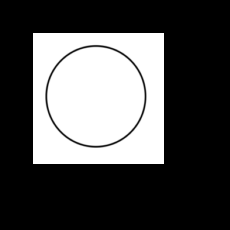

small


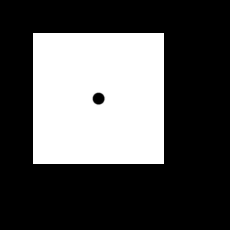

In [7]:
import torch
from torchvision import transforms

#transforms
recep_resize = transforms.Resize((int(recep_field[0][1]-recep_field[0][0]),int(recep_field[1][1]-recep_field[1][0]))) #size of receptive field
totensor = transforms.ToTensor()
topil = transforms.ToPILImage()
norm = transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])


cirle_image_tensors = {}
#generate resized/ positioned tensors
for size in circle_images:
    
    #blank backgrounds
    circle_tensor = torch.zeros(3,224,224)
    
    #shrunk images to size of receptive field
    shrunk_circle_tensor = totensor(recep_resize(circle_images[size]))

    #position shrunk images on blanks at receptive field position
    circle_tensor[:,int(recep_field[0][0]):int(recep_field[0][1]),int(recep_field[1][0]):int(recep_field[1][1])] = shrunk_circle_tensor

    #check resultant images (whats actually going to get fed to the model)
    print(size)
    recep_circle_img = topil(circle_tensor)
    recep_circle_wt_border = ImageOps.expand(recep_circle_img, border=border, fill='black')
    display(recep_circle_wt_border)

    # normalize and unsqueeze for passing through model
    circle_tensor = norm(circle_tensor)
    circle_tensor = torch.unsqueeze(circle_tensor,0)
    circle_tensor = circle_tensor.to(device)
    
    cirle_image_tensors[size] = circle_tensor

### By activationsxgradients

The best (and unfortunately slowest) way to calculate saliency scores is by getting activations, which for kernel-wise pruning, requires 'pre-add' activations, which in turns requires a 'dissected_model'.

In [8]:
#dissect model (version of model with intermediate activation maps)
from copy import deepcopy
from circuit_pruner.dissected_Conv2d import dissect_model
dissected_model = dissect_model(deepcopy(model), store_ranks = True, device=device)
dissected_model = dissected_model.to(device)

first we want to just get 'ranks' the sorted importance scores for the components of our network. We can then use those to extract a circuit by thresholding and removing low scoring components. We'll get these scores with respect to a 'small circle' image and a 'large circle' image. The 'dissected' model has the machinery for calculating and storing these scores built in, so we really just have to run the model forward . . .

In [9]:
from circuit_pruner.dissected_Conv2d import set_across_model, set_model_target_node

#setup dissected model hyper params

'''
We set the target in our network to be our feature of interest
'''
set_model_target_node(dissected_model,layer,unit)


"""
We set the 'rank_field' of the model to be [[5,5]], the position in the activation map whose response we'd like
to preserve (in this case, the position that 'sees' our target images). 
Notice we have a list of lists as an argument, this is because we are feeding through minibatches of size 1, 
but if we had bigger minibatches (because we wanted the ranks averaged across a bunch of images) 
we could specify a different position to focus on for each image in the batch.
We also dont have to specify positions at all, we can use the arguments 'image', 'max', or 'min' in place of [[5,5]]
             'image': preserve the average of the activation map
             'max': preserve the max value of the activation map
             'min': preserve the min value of the activation map
             
             default is 'image'
"""
set_across_model(dissected_model,'rank_field',[target_position])


'''
This ones kind of interesting, it means we are going to store the activationsxgradients of our graph components as 
our importance score, rather than the absolute value of that score. This can be useful as we'll see, it could
allow us to find a circuit that increases or decreases the models response to a target image/image patch, 
rather than just preserve the response.
'''
set_across_model(dissected_model,'absolute_rank',True)



AlexNet(
  (features): Sequential(
    (0): dissected_Conv2d(
      (preadd_conv): Conv2d(3, 192, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2), groups=3, bias=False)
    )
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): dissected_Conv2d(
      (preadd_conv): Conv2d(64, 12288, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), groups=64, bias=False)
    )
    (4): ReLU()
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): dissected_Conv2d(
      (preadd_conv): Conv2d(192, 73728, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=192, bias=False)
    )
    (7): ReLU()
    (8): dissected_Conv2d(
      (preadd_conv): Conv2d(384, 98304, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=384, bias=False)
    )
    (9): ReLU()
    (10): dissected_Conv2d(
      (preadd_conv): Conv2d(256, 65536, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=256, bias=False)
    

In [10]:
#actually extract ranks by running images through model

from circuit_pruner.dissected_Conv2d import get_ranklist_from_dissected_Conv2d_modules, clear_ranks_across_model

ranks = {}
#run images through model
for size in cirle_image_tensors:
    
    in_tensor = cirle_image_tensors[size]
    
    #we want separate ranks for each image, unless we do this, 
    #all ranks are averaged for every image passed through the model.
    clear_ranks_across_model(dissected_model) 
    
    dissected_model.zero_grad()

    #Run model forward until all targets reached, we have this try/except block because the model throws a special
    #error when it reaches all its targets in order to stop the forward pass. This should really be an except
    #that checks for that special error type, but for some reason I cant get that to work across files. (This is very annoying, as it means genuine errors during the forward pass are ignored)
    try:
        outputs = dissected_model(in_tensor)
    except:
        pass
    
    #WHAT ABOUT NO TARGET NODE?
    #just run outputs.backward(), the backward pass triggers hooks through the model


    ranks[size] = get_ranklist_from_dissected_Conv2d_modules(dissected_model)



We can do things with ranks once weve extracted them, like for example calculating a 'diff' rank by simply extracting one from the other. This is why we set 'absolute rank' to False earlier. Now our diff rank will essentially be approximating 'parameters that make the models response to the first image go up, and the response to the second image go down'.

In [11]:
ranks['small-big'] = []
ranks['big-small'] = []

for l in range(len(ranks['small'])):
    ranks['small-big'].append(ranks['small'][l]-ranks['big'][l])
    ranks['big-small'].append(ranks['big'][l]-ranks['small'][l])

In [ ]:
# import pickle

# pickle.dump(ranks,open('circle_ranks.pkl','wb'))

In [4]:
# import pickle

# ranks = pickle.load(open('circle_ranks.pkl','rb'))

In [12]:
model = model.eval()
for param in model.parameters():
    param.requires_grad = False

In [13]:
#finally lets extract some circuits

from circuit_pruner.extraction import model_ranks_2_circuit_model

sparsity = .2
feature_targets = {layer:[unit]}    #I know this formatting is weird, it comes from syntax for having linear combinations of units as targets, not shown here

extractions = {}
for size in ranks:
    print(size)
    #returns two formats: a circuit, which is a new smaller neural network, and a simple weight mask
    circuit, mask = model_ranks_2_circuit_model(ranks[size],sparsity,deepcopy(model),feature_targets,device)
    extractions[size] = {'circuit':circuit,'mask':mask}

big
features_8 effective last layer
target sparsity: 0.2
total params to feature: 86592

kept params in original mask: 17319      (total params * sparsity)
original mask: 230710 params
effective mask: 221439 params
effective_sparsity: 0.1900291019955654
small
features_8 effective last layer
target sparsity: 0.2
total params to feature: 86592

kept params in original mask: 17319      (total params * sparsity)
original mask: 238918 params
effective mask: 232778 params
effective_sparsity: 0.19412878787878787
small-big
features_8 effective last layer
target sparsity: 0.2
total params to feature: 86592

kept params in original mask: 17319      (total params * sparsity)
original mask: 211654 params
effective mask: 157757 params
effective_sparsity: 0.15730090539541758
big-small
features_8 effective last layer
target sparsity: 0.2
total params to feature: 86592

kept params in original mask: 17319      (total params * sparsity)
original mask: 203430 params
effective mask: 159497 params
effecti

treat these extracted circuits like new models, you can do all the same stuff with them, like visualizations . . .

  2%|▏         | 8/512 [00:00<00:06, 78.85it/s]

big


100%|██████████| 512/512 [00:05<00:00, 87.20it/s]



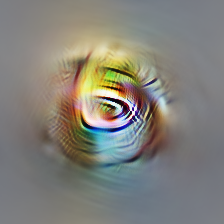

  2%|▏         | 10/512 [00:00<00:05, 93.14it/s]

small


100%|██████████| 512/512 [00:05<00:00, 87.47it/s]



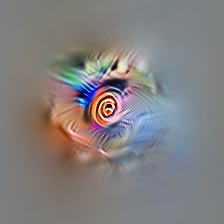

  2%|▏         | 10/512 [00:00<00:05, 94.01it/s]

small-big


100%|██████████| 512/512 [00:05<00:00, 87.53it/s]



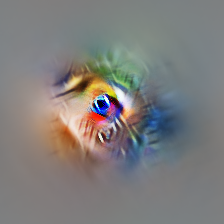

  2%|▏         | 10/512 [00:00<00:05, 95.21it/s]

big-small


100%|██████████| 512/512 [00:05<00:00, 88.05it/s]



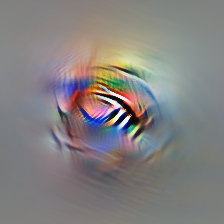

In [16]:
from lucent_fresh.optvis import render, param, transform, objectives   #lucent fresh is a version of lucent with some of my edits
from lucent_fresh.modelzoo.util import get_model_layers

'''
notice we're visualizing the same target node here, but we replace "unit" variable with "0", 
as this layer in the circuit now only has 1 feature, the target node.
'''

obj  = objectives.neuron(layer,0) 
param_f = lambda: param.image(224)

for size in extractions:
    print(size)
    _ = extractions[size]['circuit'].to(device).eval()
    _ = render.render_vis(extractions[size]['circuit'],  obj, param_f, transforms=None, show_inline=True)


In [7]:
extractions['small']['circuit']

Sequential(
  (features_0): Conv2d(3, 7, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
  (features_1): ReLU(inplace=True)
  (features_2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (features_3): Conv2d(7, 18, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (features_4): ReLU(inplace=True)
  (features_5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (features_6): Conv2d(18, 56, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (features_7): ReLU(inplace=True)
  (features_8): Conv2d(56, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

In [7]:
from circuit_pruner.extraction import fill_partial_filters_in_mask, extract_circuit_with_eff_mask


extractions['small']['mask'][0] = fill_partial_filters_in_mask(extractions['small']['mask'][0])
extractions['small']['circuit'] = extract_circuit_with_eff_mask(model,extractions['small']['mask'])


In [ ]:
from circuit_pruner.visualizer.circuit_gui import *

viz_folder = '/mnt/data/chris/dropbox/Research-Hamblin/Projects/circuit_pruner_cvpr2022/visualization_cache/big_circle_sparse.012'
launch_circuit_gui(extractions['small']['circuit'],extractions['small']['mask'],model,ranks['small'],port=8051,viz_folder=viz_folder,device=device)


already kernel ranks . . .
generating feature_viz objective string for 64
found pre-generated image
generating feature_viz objective string for 72
found pre-generated image
generating feature_viz objective string for 93
found pre-generated image
generating feature_viz objective string for 104
found pre-generated image
generating feature_viz objective string for 112
found pre-generated image
generating feature_viz objective string for 114
found pre-generated image
generating feature_viz objective string for 116
found pre-generated image
generating feature_viz objective string for 138
found pre-generated image
generating feature_viz objective string for 145
found pre-generated image
generating feature_viz objective string for 147
found pre-generated image
generating feature_viz objective string for 155
found pre-generated image
generating feature_viz objective string for 158
found pre-generated image
generating feature_viz objective string for 171
found pre-generated image
generating fea

 * Running on all addresses.
 * Running on http://140.247.95.159:8051/ (Press CTRL+C to quit)
127.0.0.1 - - [02/May/2022 17:20:50] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [02/May/2022 17:20:51] "GET /_dash-dependencies HTTP/1.1" 200 -
127.0.0.1 - - [02/May/2022 17:20:51] "GET /_dash-layout HTTP/1.1" 200 -
127.0.0.1 - - [02/May/2022 17:20:51] "GET /_dash-component-suites/dash_core_components/async-plotlyjs.v1_16_0m1617903285.js HTTP/1.1" 200 -


None
Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "/home/chris/miniconda3/envs/viscnn/lib/python3.7/site-packages/flask/app.py", line 2070, in wsgi_app
    response = self.full_dispatch_request()
  File "/home/chris/miniconda3/envs/viscnn/lib/python3.7/site-packages/flask/app.py", line 1515, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/home/chris/miniconda3/envs/viscnn/lib/python3.7/site-packages/flask/app.py", line 1513, in full_dispatch_request
    rv = self.dispatch_request()
  File "/home/chris/miniconda3/envs/viscnn/lib/python3.7/site-packages/flask/app.py", line 1499, in dispatch_request
    return self.ensure_sync(self.view_functions[rule.endpoint])(**req.view_args)
  File "/home/chris/miniconda3/envs/viscnn/lib/python3.7/site-packages/dash/dash.py", line 1079, in dispatch
    response.set_data(func(*args, outputs_list=outputs_list))
  File "/home/chris/miniconda3/envs/viscnn/lib/python3.7/site-packages/dash/da

127.0.0.1 - - [02/May/2022 17:20:52] "POST /_dash-update-component HTTP/1.1" 500 -
127.0.0.1 - - [02/May/2022 17:21:17] "POST /_dash-update-component HTTP/1.1" 200 -


{'points': [{'curveNumber': 2, 'pointNumber': 21, 'pointIndex': 21, 'x': 10, 'y': -6.5, 'text': '399', 'customdata': [399, 143, 1]}]}
fig.clickData
399
0.019440650939941406


127.0.0.1 - - [02/May/2022 17:22:01] "POST /_dash-update-component HTTP/1.1" 200 -


{'points': [{'curveNumber': 30, 'pointNumber': 2, 'pointIndex': 2, 'x': 2, 'y': 1.7999999999999998}]}
fig.clickData
resetting graph opacity
0.01441049575805664


127.0.0.1 - - [02/May/2022 17:22:15] "POST /_dash-update-component HTTP/1.1" 200 -


{'points': [{'curveNumber': 0, 'pointNumber': 0, 'pointIndex': 0, 'x': 0, 'y': -3, 'text': '12', 'customdata': [12, 12, 1]}]}
fig.clickData
12
0.01817154884338379


127.0.0.1 - - [02/May/2022 17:22:20] "POST /_dash-update-component HTTP/1.1" 200 -


{'points': [{'curveNumber': 0, 'pointNumber': 0, 'pointIndex': 0, 'x': 0, 'y': -3, 'text': '12', 'marker.opacity': 0.99, 'customdata': [12, 12, 1]}]}
fig.clickData
resetting graph opacity
0.014051675796508789


127.0.0.1 - - [02/May/2022 17:22:26] "POST /_dash-update-component HTTP/1.1" 200 -


{'points': [{'curveNumber': 0, 'pointNumber': 0, 'pointIndex': 0, 'x': 0, 'y': -3, 'text': '12', 'customdata': [12, 12, 1]}]}
fig.clickData
12
0.019385576248168945


127.0.0.1 - - [02/May/2022 17:22:34] "POST /_dash-update-component HTTP/1.1" 200 -


{'points': [{'curveNumber': 0, 'pointNumber': 0, 'pointIndex': 0, 'x': 0, 'y': -3, 'text': '12', 'customdata': [12, 12, 1]}]}
feat_size.value
0.0004909038543701172


127.0.0.1 - - [02/May/2022 17:22:52] "POST /_dash-update-component HTTP/1.1" 200 -


{'points': [{'curveNumber': 0, 'pointNumber': 0, 'pointIndex': 0, 'x': 0, 'y': -3, 'text': '12', 'customdata': [12, 12, 1]}]}
kernel_size.value
0.001001596450805664


127.0.0.1 - - [02/May/2022 17:23:16] "POST /_dash-update-component HTTP/1.1" 200 -


{'points': [{'curveNumber': 2, 'pointNumber': 33, 'pointIndex': 33, 'x': 10, 'y': 5.5, 'text': '495', 'customdata': [495, 239, 0.4648476839065552]}]}
fig.clickData
resetting graph opacity
0.014777898788452148


127.0.0.1 - - [02/May/2022 17:23:20] "POST /_dash-update-component HTTP/1.1" 200 -


{'points': [{'curveNumber': 1, 'pointNumber': 15, 'pointIndex': 15, 'x': 5, 'y': 6.5, 'text': '232', 'customdata': [232, 168, 0.8230839967727661]}]}
fig.clickData
232
0.01879572868347168


127.0.0.1 - - [02/May/2022 17:23:52] "POST /_dash-update-component HTTP/1.1" 200 -


{'points': [{'curveNumber': 1, 'pointNumber': 15, 'pointIndex': 15, 'x': 5, 'y': 6.5, 'text': '232', 'customdata': [232, 168, 0.8230839967727661]}]}
kernel_size.value
0.0005574226379394531


127.0.0.1 - - [02/May/2022 17:23:54] "POST /_dash-update-component HTTP/1.1" 200 -


{'points': [{'curveNumber': 1, 'pointNumber': 15, 'pointIndex': 15, 'x': 5, 'y': 6.5, 'text': '232', 'customdata': [232, 168, 0.8230839967727661]}]}
feat_size.value
0.00047206878662109375


127.0.0.1 - - [02/May/2022 17:24:35] "POST /_dash-update-component HTTP/1.1" 200 -


{'points': [{'curveNumber': 2, 'pointNumber': 10, 'pointIndex': 10, 'x': 10, 'y': -17.5, 'text': '344', 'customdata': [344, 88, 0.5557554960250854]}]}
fig.clickData
resetting graph opacity
0.014804840087890625


127.0.0.1 - - [02/May/2022 17:24:43] "POST /_dash-update-component HTTP/1.1" 200 -


{'points': [{'curveNumber': 2, 'pointNumber': 8, 'pointIndex': 8, 'x': 10, 'y': -19.5, 'text': '320', 'customdata': [320, 64, 0.41820207238197327]}]}
fig.clickData
320
0.018320322036743164


127.0.0.1 - - [02/May/2022 17:24:52] "POST /_dash-update-component HTTP/1.1" 200 -


{'points': [{'curveNumber': 161, 'pointNumber': 3, 'pointIndex': 3, 'x': 8, 'y': 1.1000000000000005}]}
fig.clickData
resetting graph opacity
0.014932632446289062


127.0.0.1 - - [02/May/2022 17:24:56] "POST /_dash-update-component HTTP/1.1" 200 -


{'points': [{'curveNumber': 2, 'pointNumber': 18, 'pointIndex': 18, 'x': 10, 'y': -9.5, 'text': '376', 'customdata': [376, 120, 0.5487622022628784]}]}
fig.clickData
376
0.01858997344970703


127.0.0.1 - - [02/May/2022 17:25:10] "POST /_dash-update-component HTTP/1.1" 200 -


{'points': [{'curveNumber': 115, 'pointNumber': 4, 'pointIndex': 4, 'x': 9, 'y': -7.7}]}
fig.clickData
resetting graph opacity
0.013354778289794922


127.0.0.1 - - [02/May/2022 17:25:17] "POST /_dash-update-component HTTP/1.1" 200 -


{'points': [{'curveNumber': 115, 'pointNumber': 4, 'pointIndex': 4, 'x': 9, 'y': -7.7}]}
kernel_size.value
0.0005178451538085938


127.0.0.1 - - [02/May/2022 17:25:21] "POST /_dash-update-component HTTP/1.1" 200 -


{'points': [{'curveNumber': 115, 'pointNumber': 4, 'pointIndex': 4, 'x': 9, 'y': -7.7}]}
feat_size.value
0.0005931854248046875


127.0.0.1 - - [02/May/2022 17:25:35] "POST /_dash-update-component HTTP/1.1" 200 -


{'points': [{'curveNumber': 2, 'pointNumber': 26, 'pointIndex': 26, 'x': 10, 'y': -1.5, 'text': '454', 'customdata': [454, 198, 0.36298635601997375]}]}
fig.clickData
454
0.018464326858520508


127.0.0.1 - - [02/May/2022 17:25:42] "POST /_dash-update-component HTTP/1.1" 200 -


{'points': [{'curveNumber': 2, 'pointNumber': 28, 'pointIndex': 28, 'x': 10, 'y': 0.5, 'text': '466', 'customdata': [466, 210, 0.3538042902946472]}]}
fig.clickData
resetting graph opacity
0.016872167587280273


what about the negative visualizations?

big


100%|██████████| 512/512 [00:05<00:00, 97.33it/s] 



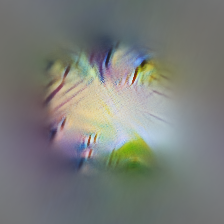

  2%|▏         | 9/512 [00:00<00:06, 80.47it/s]

small


100%|██████████| 512/512 [00:05<00:00, 89.04it/s]



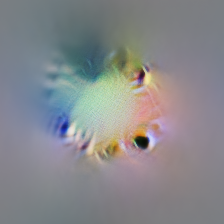

  2%|▏         | 11/512 [00:00<00:04, 108.29it/s]

small-big


100%|██████████| 512/512 [00:04<00:00, 113.78it/s]



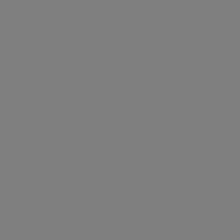

  2%|▏         | 12/512 [00:00<00:04, 116.31it/s]

big-small


100%|██████████| 512/512 [00:04<00:00, 115.16it/s]



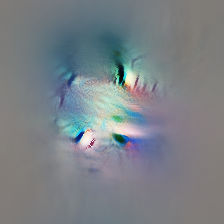

In [10]:

obj  = -objectives.neuron(layer,0) 
param_f = lambda: param.image(224)

for size in extractions:
    print(size)
    _ = extractions[size]['circuit'].to(device).eval()
    _ = render.render_vis(extractions[size]['circuit'],  obj, param_f, transforms=None, show_inline=True)


In [ ]:
# clear some space
del extractions
del ranks

### Squares? 

We've show how separate circuits account for invariance to circle size, what about its variance to squares (filter doesn't like them), can we addition find a circuit for that?

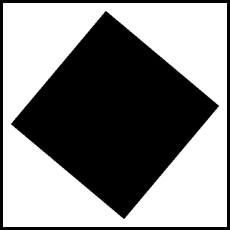

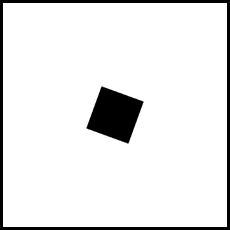

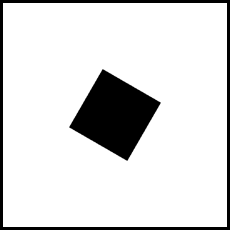

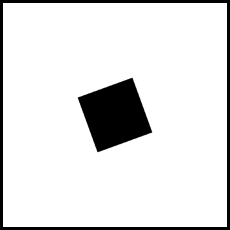

In [13]:
#Making square images
from PIL import Image, ImageOps


    
def make_square_image(square_size = 200,img_size=500,background_c =(255,255,255),square_c=(0,0,0),rot=0):
    background_img = Image.new("RGB", (img_size, img_size), background_c)
    square_img = Image.new("RGB", (square_size, square_size), square_c)
    square_img = square_img.rotate(rot, Image.BILINEAR, expand = 1,fillcolor = background_c)
    pos = (int(img_size/2 - square_img._size[0]/2),int(img_size/2 - square_img._size[1]/2))
    Image.Image.paste(background_img, square_img, pos)
    return background_img


square_params = {
                 'size':[330,100,150,130],
                 'rot': [50,70,60,20]
                }
list

for i in range(len(square_params['size'])):
    square_img = make_square_image(square_size = square_params['size'][i], rot=square_params['rot'][i])
    square_img = square_img.resize((224,224))
    square_img_wt_border = ImageOps.expand(square_img, border=border, fill='black')
    
    display(square_img_wt_border)

how does our circle filter respond to the square across scales and rotations? Well plot a scatter plot of activations as a function of scale and rotation

First we'll use the above square image generator to generate a dataloader with images across scales and rotations

In [43]:
import torch.utils.data as data
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms, utils

totensor = transforms.ToTensor()
topil = transforms.ToPILImage()
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])])
#transform = transforms.Compose([transforms.ToTensor()])


half_degrees = []
for i in range(181):
    half_degrees.append(i/2)

class square_image_data(Dataset):

    def __init__(self, sizes = list(range(30,330,2)),rotations=half_degrees,background_c =(255,255,255),square_c=(0,0,0), transform=None, recep_field=None, img_size=224):


        self.sizes = sizes
        self.rotations = rotations
        self.background_c = background_c
        self.square_c = square_c
        self.img_size = img_size
        
        self.recep_field = recep_field
        if self.recep_field:
            self.recep_resize = transforms.Resize((int(recep_field[0][1]-recep_field[0][0]),int(recep_field[1][1]-recep_field[1][0]))) #size of receptive field    
        
        if not transform:
            self.transform = transforms.ToTensor()
        else:
            self.transform = transform

    def __len__(self):
        return len(self.sizes)*len(self.rotations)    

    def __getitem__(self, idx):
        rot = self.rotations[(idx // len(self.sizes))]
        size = self.sizes[idx%len(self.sizes)]
        img = make_square_image(square_size = size,background_c = self.background_c,square_c=self.square_c,rot=rot)
        
        if self.recep_field is not None:
            #blank backgrounds
            img_tensor = torch.zeros(3,self.img_size,self.img_size)
            #shrunk images to size of receptive field
            shrunk_tensor = totensor(self.recep_resize(img))
            #position shrunk images on blanks at receptive field position
            img_tensor[:,int(self.recep_field[0][0]):int(self.recep_field[0][1]),int(self.recep_field[1][0]):int(self.recep_field[1][1])] = shrunk_tensor
            img = topil(img_tensor)
     
        img = self.transform(img).float()

        return (img,(size,rot))
    

kwargs = {'num_workers': 4, 'pin_memory': True, 'sampler':None} if 'cuda' in device else {}


dset = square_image_data(transform = transform,recep_field = recep_field)
square_loader = data.DataLoader(dset,
                                batch_size=500,
                                shuffle=False,
                                **kwargs)


In [44]:
'''


test_dset = square_image_data(sizes = [200,200],rotations = [0,90],transform = transform,recep_field = recep_field)
test_loader = data.DataLoader(test_dset,
                                batch_size=2,
                                shuffle=False,
                                **kwargs)

iter_dataloader = iter(test_loader)
iters = len(iter_dataloader)

#for it in range(iters):

inputs, img_data = next(iter_dataloader)
torch.all(inputs[0]== inputs[1])
#     img = inputs[it]
#     img = topil(img)
#     img_wt_border = ImageOps.expand(img, border=border, fill='black')
#     print((int(img_data[0][it]),int(img_data[1][it])))
#     display(img_wt_border)

'''


"\n\n\ntest_dset = square_image_data(sizes = [200,200],rotations = [0,90],transform = transform,recep_field = recep_field)\ntest_loader = data.DataLoader(test_dset,\n                                batch_size=2,\n                                shuffle=False,\n                                **kwargs)\n\niter_dataloader = iter(test_loader)\niters = len(iter_dataloader)\n\n#for it in range(iters):\n\ninputs, img_data = next(iter_dataloader)\ntorch.all(inputs[0]== inputs[1])\n#     img = inputs[it]\n#     img = topil(img)\n#     img_wt_border = ImageOps.expand(img, border=border, fill='black')\n#     print((int(img_data[0][it]),int(img_data[1][it])))\n#     display(img_wt_border)\n\n"

We are ready to get activations from our target circle feature, let's do that with a version of the model that's not 'dissected', as that runs slow. We'll use this machinery later to extract circuits from our model in another way

In [45]:
from circuit_pruner.force import setup_net_for_circuit_prune, show_model_layer_names

from torchvision import models
model = models.alexnet(pretrained=True)
model = model.to(device)

prunable_model = deepcopy(model)
_ = prunable_model.to(device)

feature_targets = {layer:[unit]}

setup_net_for_circuit_prune(prunable_model, feature_targets=feature_targets,save_target_activations=True)

features_8 effective last layer


passing data through the model will now automatically save target feature activations

In [46]:
from circuit_pruner.force import TargetReached, get_saved_target_activations_from_net
import numpy as np

#activations_list = []
#rotations_list = []
#sizes_list = []
activations = np.zeros((len(dset.sizes),len(dset.rotations)))

iter_dataloader = iter(square_loader)
iters = len(iter_dataloader)

for it in range(iters):

    inputs, img_data = next(iter_dataloader)
    inputs = inputs.to(device)
    try:
        output = prunable_model(inputs)
    except TargetReached:
        pass
    acts = get_saved_target_activations_from_net(prunable_model)[layer+':'+str(unit)].cpu().detach().numpy().astype('float32')
    acts_at_pos = list(acts[:,target_position[0],target_position[1]])
    for i in range(len(acts_at_pos)):
        size_ind = dset.sizes.index(img_data[0].numpy()[i])
        rot_ind = dset.rotations.index(img_data[1].numpy()[i])
        activations[size_ind,rot_ind] = acts_at_pos[i]              
    #activations_list += list(acts_at_pos) 
    #sizes_list += list(img_data[0].numpy())
    #rotations_list += list(img_data[1].numpy())


In [48]:
import plotly.graph_objects as go

import pandas as pd



fig = go.Figure(data=[go.Surface(z=activations,x=dset.rotations, y=dset.sizes)])

fig.update_layout(title='circle feature activations to square (by rotation and size)',
                  scene = dict(
                    xaxis_title="Rotation (degrees)",
                    yaxis_title="Size",
                    zaxis_title='Activation'),
                    scene_aspectmode='cube')



fig.show()

In [49]:
fig.write_html("plots/circle_feature_square_acts.html")

Seems like there are two big wells around diamonds at 2 sizes. Lets make a subgraph that will try to preserve the one of these 'well' (mimimum is at size 180, rot 75 deg, with ~-30 activation)

In [50]:
#get data

minsquare_dset = square_image_data(sizes =  list(range(120,240,10)), rotations = list(range(65,85,2)), transform = transform,recep_field = recep_field)
minsquare_loader = data.DataLoader(minsquare_dset,
                                batch_size=5,
                                shuffle=False,
                                **kwargs)



In [51]:
#get ranks

from circuit_pruner.dissected_Conv2d import get_ranklist_from_dissected_Conv2d_modules, clear_ranks_across_model


clear_ranks_across_model(dissected_model)   
dissected_model.zero_grad()



iter_dataloader = iter(minsquare_loader)
iters = len(iter_dataloader)

#when passing multiple images just run the model and everything will average
for it in range(iters):
    input_batch, img_data = next(iter_dataloader)
    input_batch = input_batch.to(device)
    try:
        outputs = dissected_model(input_batch)
    except:
        pass
    
    #WHAT ABOUT NO TARGET NODE?
    #just run outputs.backward(), the backward pass triggers hooks through the model


minsquare_ranks = get_ranklist_from_dissected_Conv2d_modules(dissected_model)



In [52]:
flipped_minsquare_ranks = []
for i in range(len(minsquare_ranks)):
    flipped_minsquare_ranks.append(-minsquare_ranks[i])
    
abs_minsquare_ranks = []
for i in range(len(minsquare_ranks)):
    abs_minsquare_ranks.append(torch.abs(minsquare_ranks[i]))


In [53]:
#finally lets extract some circuits

from circuit_pruner.extraction import model_ranks_2_circuit_model

sparsity = .05
feature_targets = {layer:[unit]}    #I know this formatting is weird, it comes from syntax for having linear combinations of units as targets, not shown here


#model loading
from torchvision import models
model = models.alexnet(pretrained=True)
model = model.to(device)

#returns two formats: a circuit, which is a new smaller neural network, and a simple weight mask
circuit, mask = model_ranks_2_circuit_model(abs_minsquare_ranks,sparsity,model,feature_targets,device)
minsquare_circuit = {'circuit':circuit,'mask':mask}




features_8 effective last layer
target sparsity: 0.05
total params to feature: 86592
kept params in original mask: 4330
original mask: 4330 kernels
effective mask: 2738 kernels
effective_sparsity: 0.03161954915003695


  2%|▏         | 11/512 [00:00<00:04, 100.73it/s]

positive


100%|██████████| 512/512 [00:05<00:00, 89.16it/s]



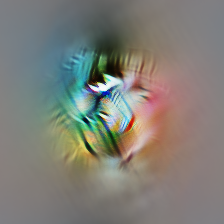

  2%|▏         | 10/512 [00:00<00:05, 95.65it/s]

negative


100%|██████████| 512/512 [00:05<00:00, 90.01it/s]



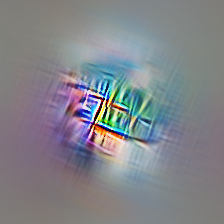

In [54]:
#visualization
from lucent_fresh.optvis import render, param, transform, objectives   #lucent fresh is a version of lucent with some of my edits
from lucent_fresh.modelzoo.util import get_model_layers


param_f = lambda: param.image(224)
obj  = objectives.neuron(layer,unit)

obj  = objectives.neuron(layer,0) #we use 0 as the unit now 


_ = minsquare_circuit['circuit'].to(device).eval()
print('positive')
_ = render.render_vis(minsquare_circuit['circuit'],  obj, param_f, transforms=None, show_inline=True)
print('negative')
_ = render.render_vis(minsquare_circuit['circuit'],  -obj, param_f, transforms=None, show_inline=True)

How do activations to the squares change with our circuits?

In [55]:
from circuit_pruner.force import TargetReached, get_saved_target_activations_from_net
import numpy as np


circuit_model = minsquare_circuit['circuit']

_ = circuit_model.to(device)

circuit_feature_targets = {layer:[0]}

setup_net_for_circuit_prune(circuit_model, feature_targets=circuit_feature_targets,save_target_activations=True)
#activations_list = []
#rotations_list = []
#sizes_list = []
activations = np.zeros((len(dset.sizes),len(dset.rotations)))

iter_dataloader = iter(square_loader)
iters = len(iter_dataloader)

for it in range(iters):

    inputs, img_data = next(iter_dataloader)
    inputs = inputs.to(device)
    try:
        output = circuit_model(inputs)
    except TargetReached:
        pass
    acts = get_saved_target_activations_from_net(circuit_model)[layer+':'+str(0)].cpu().detach().numpy().astype('float32')
    acts_at_pos = list(acts[:,target_position[0],target_position[1]])
    for i in range(len(acts_at_pos)):
        size_ind = dset.sizes.index(img_data[0].numpy()[i])
        rot_ind = dset.rotations.index(img_data[1].numpy()[i])
        activations[size_ind,rot_ind] = acts_at_pos[i]              
    #activations_list += list(acts_at_pos) 
    #sizes_list += list(img_data[0].numpy())
    #rotations_list += list(img_data[1].numpy())


features_8 effective last layer


In [56]:
import plotly.graph_objects as go

import pandas as pd



fig = go.Figure(data=[go.Surface(z=activations,x=dset.rotations, y=dset.sizes)])

fig.update_layout(title='circle feature activations to square (by rotation and size)',
                  scene = dict(
                    xaxis_title="Rotation (degrees)",
                    yaxis_title="Size",
                    zaxis_title='Activation'),
                    scene_aspectmode='cube')



fig.show()

In [57]:
fig.write_html("plots/circle_feature_rot75_square_circuit_acts.html")

works great, what about the other well, for a different rotation (minimum at 12 degrees)   ?

In [21]:
#get data

minsquare_dset = square_image_data(sizes =  list(range(120,240,10)), rotations = list(range(7,22,2)), transform = transform,recep_field = recep_field)
minsquare_loader = data.DataLoader(minsquare_dset,
                                batch_size=2,
                                shuffle=False,
                                **kwargs)


#clear some space
#model.to('cpu')
#del model
_ = prunable_model.to('cpu')


#get ranks

from circuit_pruner.dissected_Conv2d import get_ranklist_from_dissected_Conv2d_modules, clear_ranks_across_model


clear_ranks_across_model(dissected_model)   
dissected_model.zero_grad()



iter_dataloader = iter(minsquare_loader)
iters = len(iter_dataloader)

#when passing multiple images just run the model and everything will average
for it in range(iters):
    input_batch, img_data = next(iter_dataloader)
    input_batch = input_batch.to(device)
    try:
        outputs = dissected_model(input_batch)
    except:
        pass
    
    #WHAT ABOUT NO TARGET NODE?
    #just run outputs.backward(), the backward pass triggers hooks through the model


minsquare_ranks = get_ranklist_from_dissected_Conv2d_modules(dissected_model)


flipped_minsquare_ranks = []
for i in range(len(minsquare_ranks)):
    flipped_minsquare_ranks.append(-minsquare_ranks[i])
    
abs_minsquare_ranks = []
for i in range(len(minsquare_ranks)):
    abs_minsquare_ranks.append(torch.abs(minsquare_ranks[i]))

    


In [22]:
#finally lets extract some circuits

from circuit_pruner.extraction import model_ranks_2_circuit_model

sparsity = .05
feature_targets = {layer:[unit]}    #I know this formatting is weird, it comes from syntax for having linear combinations of units as targets, not shown here


#model loading
from torchvision import models
model = models.alexnet(pretrained=True)
model = model.to(device)

#returns two formats: a circuit, which is a new smaller neural network, and a simple weight mask
circuit, mask = model_ranks_2_circuit_model(abs_minsquare_ranks,sparsity,model,feature_targets,device)
minsquare_circuit = {'circuit':circuit,'mask':mask}



features_8 effective last layer
target sparsity: 0.05
total params to feature: 86592
kept params in original mask: 4330
original mask: 4330 kernels
effective mask: 2639 kernels
effective_sparsity: 0.030476256467110125


  2%|▏         | 8/512 [00:00<00:06, 73.64it/s]

positive


100%|██████████| 512/512 [00:05<00:00, 85.42it/s]



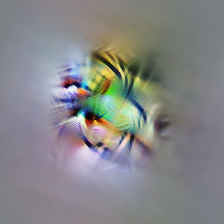

  2%|▏         | 10/512 [00:00<00:05, 92.59it/s]

negative


100%|██████████| 512/512 [00:06<00:00, 84.48it/s]



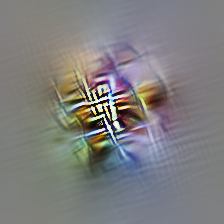

In [23]:
#visualization
from lucent_fresh.optvis import render, param, transform, objectives   #lucent fresh is a version of lucent with some of my edits
from lucent_fresh.modelzoo.util import get_model_layers


param_f = lambda: param.image(224)
obj  = objectives.neuron(layer,unit)

obj  = objectives.neuron(layer,0) #we use 0 as the unit now 


_ = minsquare_circuit['circuit'].to(device).eval()
print('positive')
_ = render.render_vis(minsquare_circuit['circuit'],  obj, param_f, transforms=None, show_inline=True)
print('negative')
_ = render.render_vis(minsquare_circuit['circuit'],  -obj, param_f, transforms=None, show_inline=True)

In [24]:
from circuit_pruner.force import TargetReached, get_saved_target_activations_from_net
import numpy as np


circuit_model = minsquare_circuit['circuit']

_ = circuit_model.to(device)

circuit_feature_targets = {layer:[0]}

setup_net_for_circuit_prune(circuit_model, feature_targets=circuit_feature_targets,save_target_activations=True)
#activations_list = []
#rotations_list = []
#sizes_list = []
activations = np.zeros((len(dset.sizes),len(dset.rotations)))

iter_dataloader = iter(square_loader)
iters = len(iter_dataloader)

for it in range(iters):

    inputs, img_data = next(iter_dataloader)
    inputs = inputs.to(device)
    try:
        output = circuit_model(inputs)
    except TargetReached:
        pass
    acts = get_saved_target_activations_from_net(circuit_model)[layer+':'+str(0)].cpu().detach().numpy().astype('float32')
    acts_at_pos = list(acts[:,target_position[0],target_position[1]])
    for i in range(len(acts_at_pos)):
        size_ind = dset.sizes.index(img_data[0].numpy()[i])
        rot_ind = dset.rotations.index(img_data[1].numpy()[i])
        activations[size_ind,rot_ind] = acts_at_pos[i]              
    #activations_list += list(acts_at_pos) 
    #sizes_list += list(img_data[0].numpy())
    #rotations_list += list(img_data[1].numpy())

features_8 effective last layer


In [25]:
import plotly.graph_objects as go

import pandas as pd



fig = go.Figure(data=[go.Surface(z=activations,x=dset.rotations, y=dset.sizes)])

fig.update_layout(title='circle feature activations to square (by rotation and size)',
                  scene = dict(
                    xaxis_title="Rotation (degrees)",
                    yaxis_title="Size",
                    zaxis_title='Activation'),
                    scene_aspectmode='cube')



fig.show()

In [26]:
fig.write_html("plots/circle_feature_rot12_square_circuit_acts.html")

### By weightsxgradients

weightsxgradients uses a slightly different api, and does not require a 'dissected_model' making everything faster, but the ranks aren't as good

In [4]:
from circuit_pruner.force import setup_net_for_circuit_prune, show_model_layer_names


_ = model.to('cpu')
prunable_model = deepcopy(model)
_ = prunable_model.to(device)
setup_net_for_circuit_prune(prunable_model)


In [6]:
layer = 'classifier_4'
unit = 10

feature_targets = {layer:[unit]}

100%|██████████| 512/512 [00:20<00:00, 24.57it/s]



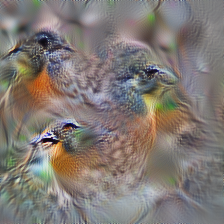

In [9]:
from lucent_fresh.optvis import render, param, transform, objectives   #lucent fresh is a version of lucent with some of my edits
from lucent_fresh.modelzoo.util import get_model_layers

param_f = lambda: param.image(224)
obj_pos  = objectives.channel(layer,unit)
obj_neg = -objectives.channel(layer,unit)
_ = render.render_vis(prunable_model,  'classifier_6:10', param_f, show_inline=True) #weird hack here using the 'dissected_model' works better for neuron-wise feature visualizations, not sure why

In [17]:
from circuit_pruner.data_loading import rank_image_data, single_image_data


#make single image data loaders

kwargs = {'num_workers': 4, 'pin_memory': True, 'sampler':None} if 'cuda' in device else {}


dataloaders = {'small':
    
}


side_face_image_loader = data.DataLoader(single_image_data(faces_path+side_img_name,
                                            config.preprocess,
                                            ),
                                            batch_size=1,
                                            shuffle=False,
                                            **kwargs)


front_face_image_loader = data.DataLoader(single_image_data(faces_path+front_img_name,
                                            config.preprocess,
                                            ),
                                            batch_size=1,
                                            shuffle=False,
                                            **kwargs)